In [1]:
import sys
import h5py
import numpy as np
import healpy as hp
import tensorflow as tf
import random as python_random
import nnhealpix.layers
import matplotlib.pyplot as plt
from tensorflow.keras import metrics
import keras
import pandas as pd
import os, shutil
import NN_functions as nuf
from loss_functions import sigma_loss, sigma_f_loss, sigma2_loss,sigma_batch_loss,sigma_norm_loss,sigma_log_loss,mse_tau,mse_sigma

2023-06-25 13:46:46.732975: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-25 13:46:47.986358: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-06-25 13:46:47.986487: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-06-25 13:46:47.986504: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
#metrics= [sigma_loss,sigma2_loss,sigma_batch_loss,sigma_norm_loss,sigma_log_loss,mse_tau,mse_sigma]
#metrics= [sigma_loss,sigma_batch_loss,mse_tau,mse_sigma,sigma_f_loss]
metrics=[]
#home_dir="/home/amorelli/r_estimate/B_maps_white_noise/results_20_6_23/"
home_dir="/home/amorelli/E_foreground/23c_6_23/"

#r_like=[0.0,0.01,0.03,0.05,0.06] #these are the r_test of the maps on which i test the NN  - case EE white noise
#sigma_exact=[0.00011*2, 0.00152323164284316, 0.00286355246354494,0.00376209725434054,0.0024*2]
#to_load=["test_data_r000_t006_24.npz","test_data_r0010_t006_24.npz","test_data_r0030_t006_24.npz","test_data_r0050_t006_24.npz","test_data_r0060_t006_54.npz"]

#r_like=[0.0,0.001,0.005,0.007,0.01] #these are the r_test of the maps on which i test the NN - case BB white noise
#sigma_exact=[0.000225922*2, 0.000398311, 0.001017338,0.001142098,0.0015324*2] #these are the sigma computed for the 
#to_load=["test_data_r000_t006_77.npz","test_data_r001_t006_78.npz","test_data_r005_t006_79.npz",
 #        "test_data_r007_t006_80.npz","test_data_r0010_t006_81.npz"] #these are the test maps

#r_like=[0.01,0.05,0.06,0.07] #case EE foreground d0s0
#sigma_exact=[0.000728125734920537*2, 0.0019234656867673, 0.0020744684626319,0.00221000125743489] #these are the sigma computed for the 
#to_load=["test_data_r000_t001_7.npz","test_data_r000_t005_8.npz","test_data_r000_t006_9.npz","test_data_r000_t007_10.npz"] #these are the test maps

r_like=[0.01,0.05,0.06,0.07] #case EE foreground d1s1
sigma_exact=[0.00074403377826682*2,0.001945305515190439, 0.0020972936206641885 ,0.0022343595567425717] #these are the sigma computed for the 
to_load=["test_data_r000_t001_7.npz","test_data_r000_t005_8.npz","test_data_r000_t006_9.npz","test_data_r000_t007_10.npz"] #these are the test maps

#r_test using the likelihood approach
#sigma_exact=[0.00073*2, 0.000398311, 0.00207732328746706,0.002335838427700651] tau 0.01,0.06,0.07,0.08
#to_load=["test_data_005_40.npz","test_data_007_40.npz"]

#load_dir='/home/amorelli/r_estimate/B_maps_white_noise/' 
load_dir="/home/amorelli/E_foreground/"

loss_kind="var" #var
#recall var for sigma^2-()^2 and sigma for sigma-()
#what for sigma-()^2?
output_squared=True #if true means that i have sigma^2-()^2 in the loss -> sigma must be squared before computing the variance

loss_training=tf.keras.losses.MeanSquaredError() 
checkpoint_dir=home_dir+"checkpoints"
last=38
to_norm=True
map_norm=False
n_output=1
in_shape=2
nodes_per_layer=[48,256,256]
nside=16
drop=0.2
n_layers=1

In [3]:
try:
    hyperparameters=pd.read_csv(home_dir+"output.txt",delim_whitespace=True, index_col=None) #i try to read the 
    #file with the hyperparameters used in the training
except:
    print("no file to read") 
    dataframe={}
    dataframe["no data"]=["-"]
    hyperparameters=pd.DataFrame(dataframe)#if there is no file to read (because i analyse an old model) i create an 
    #empty dataframe
finally:
    None #i use this so that the program continue after the try,except
print(hyperparameters)

       name loss  noise  p_stopping  p_reduce  f_reduce        stop-reduce  \
0  23c_6_23  mse      4          20         5       0.5  val_loss-val_loss   

      lr  batch_size  n_layers nodes_per_layer comments  
0  0.001          16         1     48-256-256-           


In [4]:
f_train=np.load(home_dir+"predictions.npz")
norm=f_train["norm"]

In [5]:
files=[]
for name in to_load: 
    files.append(np.load(load_dir+name) )
x_test=[]
y_test=[]
for i,f in enumerate(files):#i take the maps and the corresponding r_test for each input file
    y_test.append(f["y_test"])
    x_test.append(f["x_test"])

model = keras.models.load_model(
    home_dir+test_model_folder,  custom_objects={'loss_training' : loss_training, 'metrics' : metrics}, 
    compile=False
) #i restore the model from the test_model folder. I need to specify the custom objects and recompile the model with the custom
#objects, thus the metrics and the loss functions
model.compile(loss=loss_training,optimizer=tf.optimizers.Adam(), metrics=metrics)

In [6]:
model=nuf.build_network(in_shape,nside,n_layers=n_layers,layer_nodes=nodes_per_layer,
                        num_output=n_output,use_normalization=[False,False,False],
                        use_drop=[False,True,False],drop=[drop,drop,drop],
                        activation_dense="relu",kernel_initializer="glorot_uniform")
model.compile(loss=loss_training, optimizer=tf.optimizers.Adam(),metrics=metrics)

2023-06-25 13:46:55.599144: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-06-25 13:46:55.599284: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (coka.fe.infn.it): /proc/driver/nvidia/version does not exist
2023-06-25 13:46:55.600372: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
files=os.listdir(checkpoint_dir)
for f in files:
    splitted = f.split("-")
    if int(splitted[2])==last:
        checkpoint_path=f
        break
print(checkpoint_path)
model.load_weights(checkpoint_dir+'/'+ checkpoint_path)

saved-weights-38-0.00727.hdf5


In [8]:
results=[]
predictions=[]
for x,y in zip(x_test,y_test): #i compute the predictions of the model for each test_set and save them in a dict
    if map_norm:
        for i in range(len(x)):
            for j in range(n_inputs):
                t=x[i,:,j]
                x[i,:,j]=nuf.normalize_data(t,t)
    results.append(model.evaluate(x,y,verbose=2) )
    pred=model.predict(x)
    #print(np.mean(pred[:,0]),np.std(pred[:,0]))
    #print(np.mean(norm),np.std(norm))
    if to_norm:
        pred=nuf.denormalize_data(pred,norm)
    predictions.append(pred)

313/313 - 8s - loss: 2.9021 - 8s/epoch - 24ms/step
313/313 [==============================] - 8s 23ms/step
313/313 - 7s - loss: 0.4838 - 7s/epoch - 22ms/step
313/313 [==============================] - 7s 23ms/step
313/313 - 7s - loss: 0.1787 - 7s/epoch - 23ms/step
313/313 [==============================] - 7s 23ms/step
313/313 - 7s - loss: 0.0247 - 7s/epoch - 22ms/step
313/313 [==============================] - 7s 23ms/step


In [9]:
r_pred=[]
r_est=[]
sigma_r=[]
mae_r=[]
skeweness_r=[]
median_r=[]
for i,p in enumerate(predictions): #i compute mean, std, etc for each set of predictions and save them in the corresponding
    #dictionaries (see above)
    r_pred.append(p)
    r_est.append(np.mean(r_pred[i]))
    sigma_r.append(np.std(r_pred[i]))
    mae_r.append(np.sum(np.abs(r_pred[i]-r_est[i]))/len(r_pred[i]))
    skeweness_r.append(np.sum(((r_pred[i]-r_est[i])/sigma_r[i])**3)/len(r_pred[i]))
    median_r.append(np.median(r_pred[i]))
#r_test=np.asarray([int(x*100)/100 for x in r_est])
#sigma_like=np.empty_like(r_test,dtype=float)
#for r in r_test:
    #i=r_like.index(r)
    #sigma_like[i]=sigma_exact[i]
d={}# i create a dictionary that stores the value of the following keywords for each test_set
d["r_test"]=r_like
d["r_est"]=r_est
d["dr"]=np.abs(np.asarray(r_like)-np.asarray(r_est))/r_est
d["median_r-r_est"]=np.asarray(median_r)-np.asarray(r_est)
d["mae_r"]=mae_r
d["skeweness_r"]=skeweness_r
d["sigma_r"]=sigma_r
d["dlike"]=np.abs(np.asarray(sigma_r)-np.asarray(sigma_exact))/sigma_r

r_data=pd.DataFrame(d)

#define new DataFrame as original DataFrame with each row repeated 3 times. I do this because i want to join the hyperpar. dataframe
#with the r_data dataframe and the hyperparam. dataframe only has one row
hp_new = pd.DataFrame(np.repeat(hyperparameters.values, len(r_est), axis=0))
#assign column names of original DataFrame to new DataFrame
hp_new.columns = hyperparameters.columns

out_df = pd.concat([hp_new, r_data], axis=1) # i join the two dataframes so that i can copy-paste all the info for one model directly
#in excel

print(out_df)
out_df.to_csv(home_dir+'results.txt', index=False, sep=';')

       name loss noise p_stopping p_reduce f_reduce        stop-reduce     lr  \
0  23c_6_23  mse     4         20        5      0.5  val_loss-val_loss  0.001   
1  23c_6_23  mse     4         20        5      0.5  val_loss-val_loss  0.001   
2  23c_6_23  mse     4         20        5      0.5  val_loss-val_loss  0.001   
3  23c_6_23  mse     4         20        5      0.5  val_loss-val_loss  0.001   

  batch_size n_layers nodes_per_layer comments  r_test     r_est        dr  \
0         16        1     48-256-256-             0.01  0.011287  0.114060   
1         16        1     48-256-256-             0.05  0.047737  0.047411   
2         16        1     48-256-256-             0.06  0.057640  0.040948   
3         16        1     48-256-256-             0.07  0.067709  0.033831   

   median_r-r_est     mae_r  skeweness_r   sigma_r     dlike  
0       -0.000083  0.000467     1.140787  0.000621  1.396659  
1       -0.000051  0.001905    -0.030243  0.002383  0.183560  
2        0.000

In [10]:
for i in range(len(r_pred)):
    print("on_test_set r =",r_like[i])
    print("r_est:",r_est[i],"  This is the average of the $r_{i}^{NN}$ estimated by the network on the test set.")
    print("sigma_r:",sigma_r[i], " This is the std of the $r_i^{NN}$ array (std of the prediction).")
    print("\n")

on_test_set r = 0.01
r_est: 0.011287442   This is the average of the $r_{i}^{NN}$ estimated by the network on the test set.
sigma_r: 0.0006208924  This is the std of the $r_i^{NN}$ array (std of the prediction).


on_test_set r = 0.05
r_est: 0.04773676   This is the average of the $r_{i}^{NN}$ estimated by the network on the test set.
sigma_r: 0.0023826691  This is the std of the $r_i^{NN}$ array (std of the prediction).


on_test_set r = 0.06
r_est: 0.057639763   This is the average of the $r_{i}^{NN}$ estimated by the network on the test set.
sigma_r: 0.0025125216  This is the std of the $r_i^{NN}$ array (std of the prediction).


on_test_set r = 0.07
r_est: 0.067709304   This is the average of the $r_{i}^{NN}$ estimated by the network on the test set.
sigma_r: 0.0027265365  This is the std of the $r_i^{NN}$ array (std of the prediction).




In [11]:
#print(r_pred[0][:100])

n_of_bins: 106
n_of_bins: 63
n_of_bins: 66
n_of_bins: 67


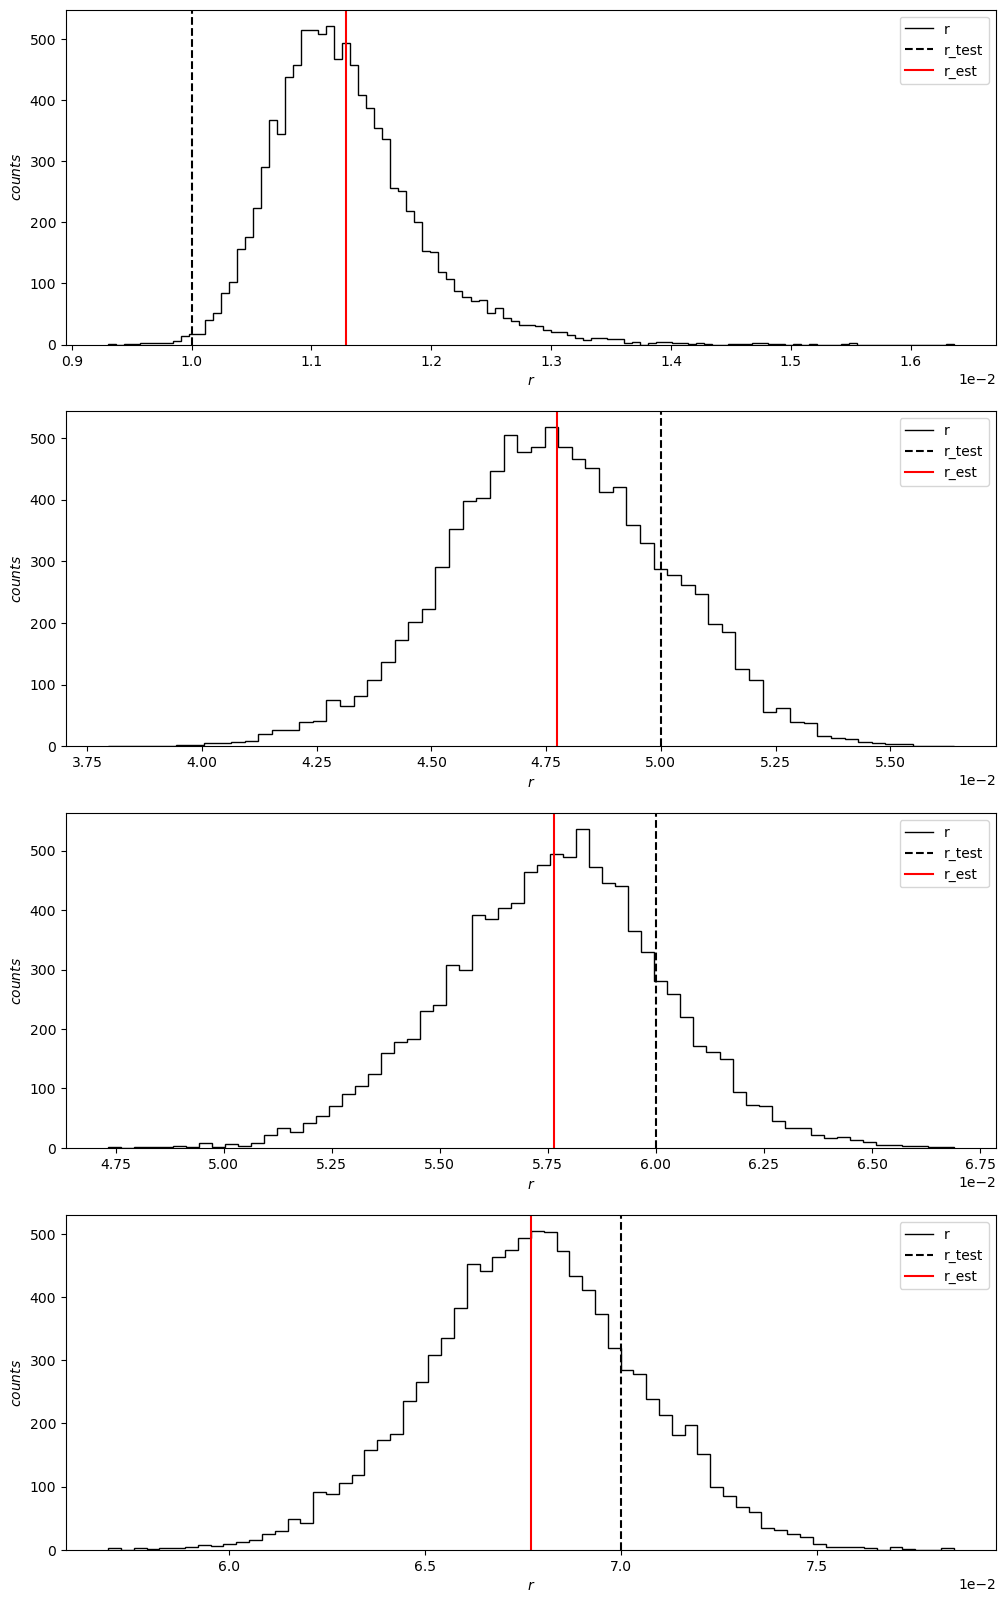

In [12]:
fig, ax = plt.subplots(len(r_pred),1, figsize = (12,20))
for i in range(len(r_pred)): #for each test_set i create an histogram of the r_pred and sigma_pred and print both 
    bin_size=100
    bin_edges= np.histogram_bin_edges(r_pred[i], bins='fd')
    print("n_of_bins:",len(bin_edges))
    counts_tau, bins_tau = np.histogram(r_pred[i], bins=bin_edges) 
    plt.subplot(len(r_pred),1,i+1)
    plt.stairs(counts_tau, bins_tau, label="r",  color='k')
    plt.axvline(r_like[i], color="black", linestyle="--", label="r_test")
    #plt.axvline(median_r[i], color="black", linestyle="--", label="r_test")
    plt.axvline(r_est[i], color="red", linestyle="-", label="r_est")
    plt.legend()
    plt.xlabel("$r$")
    plt.ylabel("$counts$")
    plt.ticklabel_format(style='sci',useOffset=True, axis='x', scilimits=[-1, 1])
    #print(counts_tau, bins_tau)
    #print(np.sort(r_pred[i]))
#plt.savefig('results_on_test.jpg') #must be in same cell or result image will be blank